## Anomaly Detection in Time Series Sensor Data

### Z-score

Z-score is a statistical measure that tells you how far is a data point from the rest of the dataset. In a more technical term, Z-score tells how many standard deviations away a given observation is from the mean.

For example, a Z score of 2.5 means that the data point is 2.5 standard deviation far from the mean. And since it is far from the center, it’s flagged as an outlier/anomaly.

CRISP - DM methodology:

- Business understanding
- Data understanding
- Data transformation
- Modeling
- Evaluation
- Deployment

### Business understanding

- The data are from sensors of water pump in one small town.

- There are 53 sensors intalled on that pump and they are actually KPIs for monitoring behaviour of the pump.

- The task is to detect unusual behaviour of the pump (failures)

- What is Time Series?

A Time Series is a sequence taken at successive equally spaced points in time. It is very important to emphasize role of time here. Observations are depending on time.

### Python Libraries

Libraries that are needed for this notebook:

- pandas - python library for working with data
- numpy - python library for different kind of calculations
- scipy - python library for statistical functions
- matplotlib and seaborn - python libraries for visualizations

Installing libraries:

- in notebook: !pip install numpy

- in terminal: pip install numpy

Requirements:

- numpy==1.19.5
- pandas==1.1.5
- scipy==1.4.1
- matplotlib==3.3.2
- seaborn==0.9.0

Checking the version of library: 
- pip freeze | grep scikit-learn

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore

### Data understanding

We will download dataset from Kaggle: 
https://www.kaggle.com/nphantawee/pump-sensor-data

In [7]:
df = pd.read_csv("../data/sensor.csv")

In [12]:
# df.to_csv('../data/sensor.csv', index=False) writing csv file

In [8]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [13]:
df.index

RangeIndex(start=0, stop=220320, step=1)

In [9]:
df.shape

(220320, 55)

In [10]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [11]:
df.timestamp.min(), df.timestamp.max() # 5 months of data

('2018-04-01 00:00:00', '2018-08-31 23:59:00')

Columns:
    
- timestamp - datetime when sensor have read value
- sensor_00-51 - names of sensors
- machine_status - column that shows if machine was in normal state, in failure or in recovering

Column Unnamed is sufficient, so we will drop it

In [17]:
df.drop(columns=['Unnamed: 0'], inplace=True)

# df = df.drop(columns=['Unnamed: 0']) # other way to remove column

In [18]:
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [19]:
df.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23',
       'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28',
       'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33',
       'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38',
       'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43',
       'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48',
       'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [20]:
df.dtypes

timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_37   

It is important to check types of columns, especially if date is categorical value (type object), we need to cast it to date:

- df['date_column'] = pd.to_datetime(df['date_column'])

If we want to cast object value to integer or float:

- df['column'] = df['column'].astype(int)

- df['column'] = df['column'].astype(float)

In [23]:
# two ways of getting the columns
df.timestamp
df['timestamp']

0         2018-04-01 00:00:00
1         2018-04-01 00:01:00
2         2018-04-01 00:02:00
3         2018-04-01 00:03:00
4         2018-04-01 00:04:00
                 ...         
220315    2018-08-31 23:55:00
220316    2018-08-31 23:56:00
220317    2018-08-31 23:57:00
220318    2018-08-31 23:58:00
220319    2018-08-31 23:59:00
Name: timestamp, Length: 220320, dtype: object

In [24]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [25]:
df.dtypes

timestamp         datetime64[ns]
sensor_00                float64
sensor_01                float64
sensor_02                float64
sensor_03                float64
sensor_04                float64
sensor_05                float64
sensor_06                float64
sensor_07                float64
sensor_08                float64
sensor_09                float64
sensor_10                float64
sensor_11                float64
sensor_12                float64
sensor_13                float64
sensor_14                float64
sensor_15                float64
sensor_16                float64
sensor_17                float64
sensor_18                float64
sensor_19                float64
sensor_20                float64
sensor_21                float64
sensor_22                float64
sensor_23                float64
sensor_24                float64
sensor_25                float64
sensor_26                float64
sensor_27                float64
sensor_28                float64
sensor_29 

In [26]:
df['timestamp']

0        2018-04-01 00:00:00
1        2018-04-01 00:01:00
2        2018-04-01 00:02:00
3        2018-04-01 00:03:00
4        2018-04-01 00:04:00
                 ...        
220315   2018-08-31 23:55:00
220316   2018-08-31 23:56:00
220317   2018-08-31 23:57:00
220318   2018-08-31 23:58:00
220319   2018-08-31 23:59:00
Name: timestamp, Length: 220320, dtype: datetime64[ns]

In [28]:
df.isnull().sum()

timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


We can see that sensor_15 doesn't have any value, so we can drop that column.

All of the other sensor have missing values, more or less. Now we will calculate percentage of missing values to see if is it worth filling it out or we should drop more columns. It is practice to drop every column that has more than 70% of missing values.


In [29]:
def calculate_na_percentage(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df)*100,
                        columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [30]:
calculate_na_percentage(df).head(10)

,percent
sensor_15,100.000000
sensor_50,34.956881
sensor_51,6.982117
sensor_00,4.633261
sensor_07,2.474129
sensor_08,2.317992
sensor_06,2.177741
sensor_09,2.085603
sensor_01,0.167484
sensor_30,0.118464


Percentage of missing values is low for every columns, so we will drop only column sensor_15. For the rest of the columns we need to fill missing values and we will do that with help of IterativeImputer.

IterativeImputer fills every column depending on all other columns. It can be used only for numerical columns.

- Shortcut for insert cells: B
- Shortcut for deleting cells: DD

Techniques for fillin missing values:

- ffill() - forward fill na
- bfill() - backward fill na
- mean() - fill na with average value of the column
- median()
- mode()

In [33]:
df.drop(columns='sensor_15', inplace=True)

In [34]:
# get all the columns which missing values we want to fill in
features = df.columns
features = [feature for feature in features if feature not in ['timestamp', 'machine_status']]

In [35]:
features

['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_05',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26',
 'sensor_27',
 'sensor_28',
 'sensor_29',
 'sensor_30',
 'sensor_31',
 'sensor_32',
 'sensor_33',
 'sensor_34',
 'sensor_35',
 'sensor_36',
 'sensor_37',
 'sensor_38',
 'sensor_39',
 'sensor_40',
 'sensor_41',
 'sensor_42',
 'sensor_43',
 'sensor_44',
 'sensor_45',
 'sensor_46',
 'sensor_47',
 'sensor_48',
 'sensor_49',
 'sensor_50',
 'sensor_51']

In [26]:
%%time
df[features] = IterativeImputer().fit_transform(df[features])

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


CPU times: user 44min 37s, sys: 5min 37s, total: 50min 15s
Wall time: 9min 7s


In [36]:
df.isna().sum()

timestamp             0
sensor_00         10208
sensor_01           369
sensor_02            19
sensor_03            19
sensor_04            19
sensor_05            19
sensor_06          4798
sensor_07          5451
sensor_08          5107
sensor_09          4595
sensor_10            19
sensor_11            19
sensor_12            19
sensor_13            19
sensor_14            21
sensor_16            31
sensor_17            46
sensor_18            46
sensor_19            16
sensor_20            16
sensor_21            16
sensor_22            41
sensor_23            16
sensor_24            16
sensor_25            36
sensor_26            20
sensor_27            16
sensor_28            16
sensor_29            72
sensor_30           261
sensor_31            16
sensor_32            68
sensor_33            16
sensor_34            16
sensor_35            16
sensor_36            16
sensor_37            16
sensor_38            27
sensor_39            27
sensor_40            27
sensor_41       

In [28]:
df.describe() # get descriptive statistics for numerical columns

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,...,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,2.261848,47.591444,50.867360,43.752488,590.672891,73.396496,13.346728,15.662962,15.036931,14.681360,...,35.453437,43.879539,42.656840,43.095068,48.018665,44.340863,150.890735,57.120139,209.760311,206.687502
std,0.644540,3.294353,3.666668,2.418783,144.017843,17.297522,2.397737,2.503575,2.319918,2.234783,...,10.258897,11.043730,11.575690,12.836742,15.640337,10.441807,82.240433,19.142489,68.210833,110.672834
min,-0.480434,0.000000,33.159720,31.640620,2.798032,0.000000,-0.061440,-0.765181,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,-318.281458,-345.717914
25%,2.419155,46.310760,50.390620,42.838539,626.620400,69.977213,13.317420,15.856480,15.147570,15.010130,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,182.002300,179.710887
50%,2.455556,48.133678,51.649300,44.227428,632.638916,75.576590,13.628470,16.167530,15.451390,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,214.975251,199.363400
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.911770,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,252.849521,219.907400
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [38]:
df.describe(include='object') # get descriptive statistics for categorical columns

,machine_status
count,220320
unique,3
top,NORMAL
freq,205836


In [39]:
df.describe(include='all') # get descriptive statistics for all columns

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
count,220320,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000,220320
unique,220320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,2018-08-16 16:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205836
first,2018-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-08-31 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667,NaN
std,NaN,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607,NaN
min,NaN,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779,NaN
25%,NaN,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800,NaN


In [29]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [31]:
print('Min date in dataset:', df['timestamp'].min().date())
print('Max date in dataset:', df['timestamp'].max().date())

Min date in dataset: 2018-04-01
Max date in dataset: 2018-08-31


In [40]:
train_data_minute = pd.read_csv('../data/train_data.csv')
train_data_minute['timestamp'] = pd.to_datetime(train_data_minute['timestamp'])

In [45]:
train_data_minute.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [46]:
train_data_minute.index

RangeIndex(start=0, stop=220320, step=1)

In [48]:
 train_data_minute.set_index('timestamp').index

DatetimeIndex(['2018-04-01 00:00:00', '2018-04-01 00:01:00',
               '2018-04-01 00:02:00', '2018-04-01 00:03:00',
               '2018-04-01 00:04:00', '2018-04-01 00:05:00',
               '2018-04-01 00:06:00', '2018-04-01 00:07:00',
               '2018-04-01 00:08:00', '2018-04-01 00:09:00',
               ...
               '2018-08-31 23:50:00', '2018-08-31 23:51:00',
               '2018-08-31 23:52:00', '2018-08-31 23:53:00',
               '2018-08-31 23:54:00', '2018-08-31 23:55:00',
               '2018-08-31 23:56:00', '2018-08-31 23:57:00',
               '2018-08-31 23:58:00', '2018-08-31 23:59:00'],
              dtype='datetime64[ns]', name='timestamp', length=220320, freq=None)

In [49]:
# aggregating data on hourly level
train_data_hourly = train_data_minute.set_index('timestamp').resample('H').sum()

In [51]:
train_data_minute[['sensor_00', 'sensor_01', 'sensor_02']]

,sensor_00,sensor_01,sensor_02
0,2.465394,47.09201,53.211800
1,2.465394,47.09201,53.211800
2,2.444734,47.35243,53.211800
3,2.460474,47.09201,53.168400
4,2.445718,47.13541,53.211800
...,...,...,...
220315,2.407350,47.69965,50.520830
220316,2.400463,47.69965,50.564240
220317,2.396528,47.69965,50.520830
220318,2.406366,47.69965,50.520832


We can resample on different levels:

- H - hour
- M - month
- W - week
- Q - quater
- 3D - 3 days
- ...


In [54]:
train_data_minute[['timestamp','sensor_00', 'sensor_01', 'sensor_02']].set_index('timestamp').\
                                                            resample('H').agg({'sensor_00': 'sum',
                                                                               'sensor_01': 'min', 
                                                                               'sensor_02': np.mean})

,sensor_00,sensor_01,sensor_02
timestamp,,,
2018-04-01 00:00:00,147.270375,47.048610,53.142359
2018-04-01 01:00:00,147.254637,46.484380,53.106913
2018-04-01 02:00:00,147.217251,47.482640,53.010704
2018-04-01 03:00:00,147.274309,47.395830,52.975985
2018-04-01 04:00:00,147.227091,46.701390,52.868200
...,...,...,...
2018-08-31 19:00:00,144.168464,49.001736,50.992474
2018-08-31 20:00:00,144.160594,48.611110,50.814524
2018-08-31 21:00:00,144.158628,47.960068,50.636574


In [68]:
train_data_minute['time'] = train_data_minute['timestamp'].dt.time

In [63]:
train_data_minute[['timestamp','sensor_00', 'sensor_01']].\
set_index(['timestamp', 'sensor_00']).index

MultiIndex([('2018-04-01 00:00:00',           2.465394),
            ('2018-04-01 00:01:00',           2.465394),
            ('2018-04-01 00:02:00',           2.444734),
            ('2018-04-01 00:03:00',           2.460474),
            ('2018-04-01 00:04:00',           2.445718),
            ('2018-04-01 00:05:00',           2.453588),
            ('2018-04-01 00:06:00',           2.455556),
            ('2018-04-01 00:07:00',           2.449653),
            ('2018-04-01 00:08:00', 2.4634259999999997),
            ('2018-04-01 00:09:00',           2.445718),
            ...
            ('2018-08-31 23:50:00',           2.404398),
            ('2018-08-31 23:51:00',           2.402431),
            ('2018-08-31 23:52:00',           2.404398),
            ('2018-08-31 23:53:00',           2.406366),
            ('2018-08-31 23:54:00',           2.396528),
            ('2018-08-31 23:55:00',            2.40735),
            ('2018-08-31 23:56:00', 2.4004630000000002),
            ('2

In [50]:
train_data_hourly

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,147.270375,2913.367930,3188.541524,2773.524220,38047.224500,4544.18636,801.83005,969.72643,942.15136,905.19392,...,1926.562367,2420.312290,2326.388814,3003.18286,2827.546320,2358.796255,11847.5114,4690.10433,14409.143900,12601.8518
2018-04-01 01:00:00,147.254637,2880.946110,3186.414793,2756.119694,38054.166300,4473.95323,815.58151,969.40087,942.76623,905.54113,...,1973.176927,2392.708110,2593.171300,2839.98847,2632.523120,2358.217562,10841.1461,4403.06712,13819.734100,12224.2472
2018-04-01 02:00:00,147.217251,2939.583190,3180.642243,2735.590144,38065.624300,4501.01258,815.79850,969.64682,940.06800,905.53390,...,1936.458200,2396.353953,2533.854110,3054.10881,2906.828722,2308.738394,10416.9562,4550.92593,13518.228800,12599.8262
2018-04-01 03:00:00,147.274309,2919.270780,3178.559090,2713.107514,38005.019300,4395.38262,816.26149,969.56000,941.31948,905.49048,...,1878.906216,2377.603950,3048.900480,3224.82637,2733.506987,2300.057799,12263.3102,6278.35645,15438.946800,13360.8215
2018-04-01 04:00:00,147.227091,2899.609310,3172.091999,2707.855830,38099.189200,4208.99011,815.11132,969.08983,942.12968,905.72194,...,1858.593658,2374.739390,3398.726830,4153.64580,3554.398130,2311.921252,12785.0114,6850.69434,14948.205900,12698.4953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,144.168464,2960.329747,3059.548465,2606.076268,37942.823178,4758.57540,907.62436,1000.42690,939.75695,905.85217,...,1830.729106,2470.312300,4859.664470,3127.02544,2901.620330,2488.136550,12324.6529,5211.51618,13621.540585,11815.3938
2018-08-31 20:00:00,144.160594,2926.388752,3048.871436,2613.020685,37934.258995,3869.07452,906.19210,999.89886,940.71908,904.88286,...,1815.364555,2542.708140,3083.333320,3417.82408,3864.294010,2353.009224,17492.1876,7658.56437,18298.318742,14592.8819
2018-08-31 21:00:00,144.158628,2900.216968,3038.194470,2597.482558,37904.907204,4151.58935,906.59724,999.80480,940.45139,905.85939,...,1845.572857,2385.156040,4120.949040,4951.96755,4256.365630,3386.863210,21911.4581,6587.67377,19810.993699,13746.8169


In [55]:
train_data = train_data_hourly

### Visualizations

In [56]:
train_data = train_data.sort_values(by='timestamp')

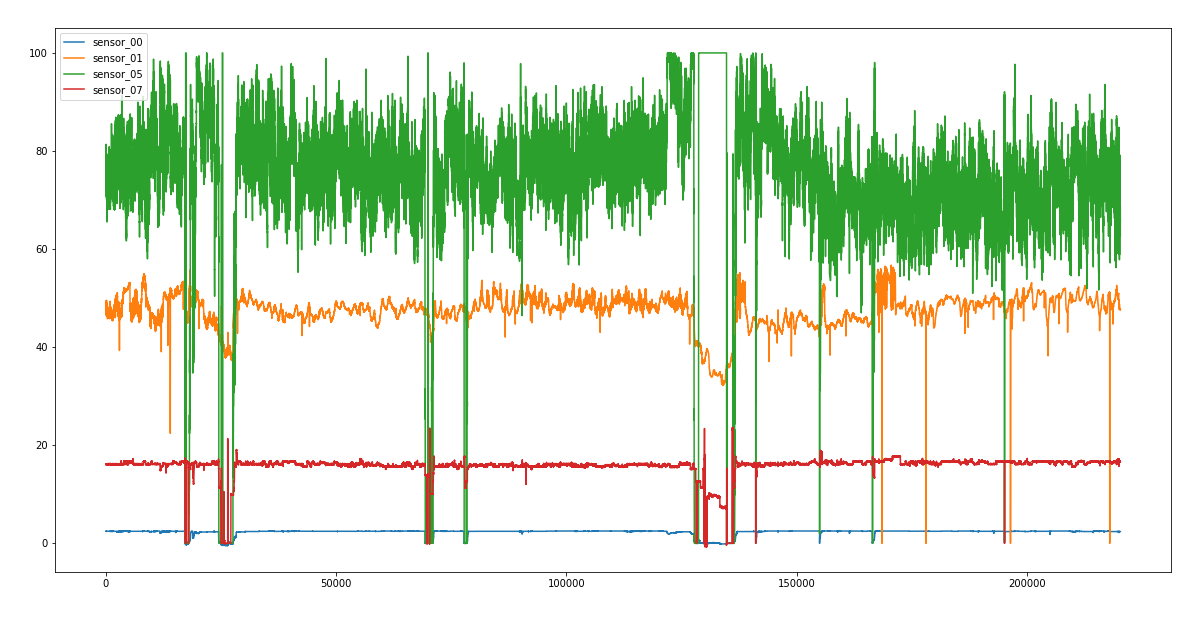

In [61]:
train_data_minute[['sensor_00','sensor_01', 'sensor_05', 'sensor_07']].plot(figsize=(20,10))
plt.xlabel("Date", fontsize=18, color='white')
plt.ylabel("Sensor value", fontsize=18, color='white')
plt.title('Sensors through time', fontsize=20, color='white');

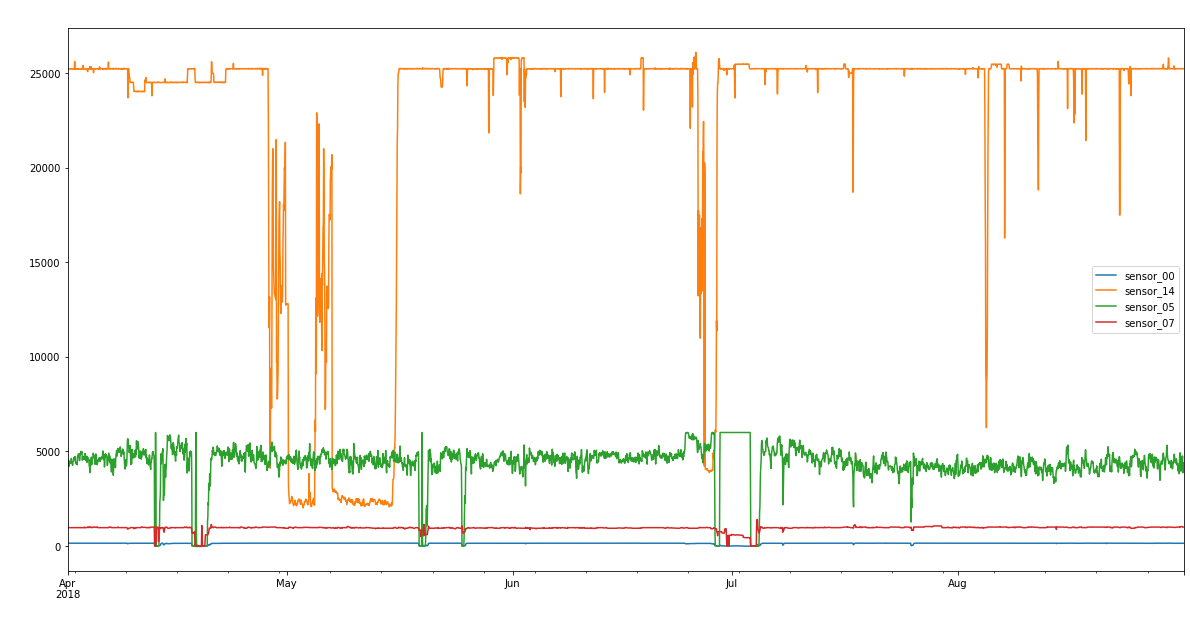

In [78]:
train_data[['sensor_00','sensor_14', 'sensor_05', 'sensor_07']].plot(figsize=(20,10))
plt.xlabel("Date", fontsize=18, color='white')
plt.ylabel("Sensor value", fontsize=18, color='white')
plt.title('Sensors through time', fontsize=20, color='white');

In [71]:
train_data_minute[train_data_minute['machine_status']=='BROKEN'].head(100)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.652800,BROKEN
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.738400,BROKEN
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.523100,BROKEN
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.361100,BROKEN
128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,169.719892,BROKEN
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.768500,BROKEN
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,269.655985,205.729200,BROKEN


In [75]:
broken_timestamp = train_data_minute[train_data_minute.machine_status=='BROKEN'][['timestamp']]

In [76]:
broken_timestamp

,timestamp
17155,2018-04-12 21:55:00
24510,2018-04-18 00:30:00
69318,2018-05-19 03:18:00
77790,2018-05-25 00:30:00
128040,2018-06-28 22:00:00
141131,2018-07-08 00:11:00
166440,2018-07-25 14:00:00


- Conclusion based on visualization is that we can predict failure based on sensors, in this case the sensor_05 is the most valuable.

### Data preparation

Here we can have scaling, normalizing of the data, train and test spit, etc.

In [87]:
cols = train_data.columns.tolist()
zScore_df = pd.DataFrame()

### Modeling

In [81]:
mean_value = train_data['sensor_00'].mean()

In [83]:
std_value = train_data['sensor_00'].std()

In [88]:
train_data['sensor_00_zscore'] = (train_data['sensor_00']-mean_value)/std_value

train_data['sensor_00_zscore'].drop(columns='sensor_00_zscore', inplace=True)

In [89]:
for col in cols:
    # apply abs because the zscore on 2 ends are the abnormals, both the positive and negative
    abs_zscore = np.abs(zscore(train_data[col]))
    # standardize the z_score in order to have values from 0 to 1
    zScore_df[str(col)+'_zscore'] = (abs_zscore - np.min(abs_zscore))/(np.max(abs_zscore) - np.min(abs_zscore))

In [90]:
# averaging the score of each feature into an overall zscore for all features
all_cols_zscore = zScore_df.mean(axis=1)
# standardization in order to have values from 0 to 1
zScore_df["all_cols_zscore"] = (all_cols_zscore - np.min(all_cols_zscore))/ \
              (np.max(all_cols_zscore) - np.min(all_cols_zscore))

zScore_df.set_index(train_data.index, inplace=True)

In [95]:
zScore_df.mean(axis=0) # every column for all rows

sensor_00_zscore           0.130145
sensor_01_zscore           0.146166
sensor_02_zscore           0.122724
sensor_03_zscore           0.142559
sensor_04_zscore           0.128853
sensor_05_zscore           0.126585
sensor_06_zscore           0.085092
sensor_07_zscore           0.065642
sensor_08_zscore           0.062190
sensor_09_zscore           0.057940
sensor_10_zscore           0.164258
sensor_11_zscore           0.202759
sensor_12_zscore           0.237753
sensor_13_zscore           0.405167
sensor_14_zscore           0.210534
sensor_16_zscore           0.188826
sensor_17_zscore           0.177818
sensor_18_zscore           0.194922
sensor_19_zscore           0.215188
sensor_20_zscore           0.189562
sensor_21_zscore           0.205896
sensor_22_zscore           0.212968
sensor_23_zscore           0.198819
sensor_24_zscore           0.205271
sensor_25_zscore           0.217324
sensor_26_zscore           0.218259
sensor_27_zscore           0.058953
sensor_28_zscore           0

In [96]:
zScore_df.mean(axis=1) # for every row for all columns

timestamp
2018-04-01 00:00:00    0.107622
2018-04-01 01:00:00    0.106549
2018-04-01 02:00:00    0.107973
2018-04-01 03:00:00    0.116333
2018-04-01 04:00:00    0.119390
                         ...   
2018-08-31 19:00:00    0.107065
2018-08-31 20:00:00    0.127402
2018-08-31 21:00:00    0.133088
2018-08-31 22:00:00    0.107430
2018-08-31 23:00:00    0.116139
Freq: H, Length: 3672, dtype: float64

In [91]:
zScore_df 

,sensor_00_zscore,sensor_01_zscore,sensor_02_zscore,sensor_03_zscore,sensor_04_zscore,sensor_05_zscore,sensor_06_zscore,sensor_07_zscore,sensor_08_zscore,sensor_09_zscore,...,sensor_44_zscore,sensor_45_zscore,sensor_46_zscore,sensor_47_zscore,sensor_48_zscore,sensor_49_zscore,sensor_50_zscore,sensor_51_zscore,sensor_00_zscore_zscore,all_cols_zscore
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0.069892,0.062627,0.128532,0.208632,0.073425,0.031858,0.001283,0.031505,0.044270,0.026557,...,0.032979,0.060156,0.004521,0.049826,0.160771,0.112113,0.051845,0.004201,0.069892,0.078934
2018-04-01 01:00:00,0.069795,0.027505,0.126529,0.184156,0.073622,0.015909,0.018483,0.031162,0.044953,0.026952,...,0.004767,0.036628,0.020994,0.049921,0.102848,0.086629,0.035087,0.003705,0.069795,0.076505
2018-04-01 02:00:00,0.069563,0.091025,0.121093,0.155284,0.073947,0.022054,0.018755,0.031421,0.041956,0.026944,...,0.003605,0.067498,0.002168,0.058098,0.078434,0.099757,0.026515,0.004158,0.069563,0.079730
2018-04-01 03:00:00,0.069917,0.069021,0.119132,0.123666,0.072227,0.001886,0.019334,0.031330,0.043346,0.026895,...,0.069291,0.092111,0.012465,0.059532,0.184703,0.253124,0.081124,0.020146,0.069917,0.098656
2018-04-01 04:00:00,0.069624,0.047722,0.113042,0.116280,0.074899,0.044212,0.017895,0.030835,0.044246,0.027158,...,0.118821,0.226023,0.056866,0.057572,0.214730,0.303938,0.067172,0.006231,0.069624,0.105577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,0.050642,0.113499,0.007067,0.026789,0.070462,0.080542,0.133613,0.063825,0.041611,0.027306,...,0.325668,0.078011,0.001728,0.028451,0.188234,0.158406,0.029452,0.012295,0.050642,0.077675
2018-08-31 20:00:00,0.050594,0.076732,0.002983,0.017023,0.070219,0.121401,0.131822,0.063269,0.042679,0.026204,...,0.074166,0.119937,0.083041,0.050782,0.485658,0.375664,0.162421,0.046031,0.050594,0.123717
2018-08-31 21:00:00,0.050581,0.048381,0.013037,0.038875,0.069386,0.057247,0.132328,0.063170,0.042382,0.027314,...,0.221077,0.341121,0.116158,0.120019,0.740014,0.280586,0.205429,0.028255,0.050581,0.136591


In [92]:
zScore_df.describe()

,sensor_00_zscore,sensor_01_zscore,sensor_02_zscore,sensor_03_zscore,sensor_04_zscore,sensor_05_zscore,sensor_06_zscore,sensor_07_zscore,sensor_08_zscore,sensor_09_zscore,...,sensor_44_zscore,sensor_45_zscore,sensor_46_zscore,sensor_47_zscore,sensor_48_zscore,sensor_49_zscore,sensor_50_zscore,sensor_51_zscore,sensor_00_zscore_zscore,all_cols_zscore
count,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,...,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,0.130145,0.146166,0.122724,0.142559,0.128853,0.126585,0.085092,0.065642,0.062190,0.057940,...,0.050175,0.056418,0.039782,0.053453,0.226104,0.061229,0.080363,0.054217,0.130145,0.183622
std,0.199644,0.154065,0.166730,0.145194,0.206920,0.191546,0.154745,0.139796,0.136518,0.134046,...,0.058948,0.071537,0.049284,0.062322,0.149520,0.069350,0.078736,0.126302,0.199644,0.215486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.069636,0.051981,0.038323,0.052875,0.068898,0.035239,0.017861,0.024900,0.010099,0.026475,...,0.016288,0.020457,0.014345,0.018350,0.108808,0.021497,0.026842,0.011045,0.069636,0.061764
50%,0.069917,0.107074,0.077302,0.110390,0.073853,0.073696,0.040036,0.032000,0.040916,0.026919,...,0.036380,0.039772,0.029793,0.038109,0.209283,0.042311,0.056896,0.023476,0.069917,0.094284
75%,0.088894,0.180473,0.136317,0.179410,0.078607,0.124552,0.095203,0.063006,0.043195,0.027561,...,0.064217,0.065843,0.048429,0.065091,0.315338,0.069446,0.102442,0.042329,0.088894,0.139708
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
zScore_df.sort_values(by='all_cols_zscore', ascending=False).head(10)

,sensor_00_zscore,sensor_01_zscore,sensor_02_zscore,sensor_03_zscore,sensor_04_zscore,sensor_05_zscore,sensor_06_zscore,sensor_07_zscore,sensor_08_zscore,sensor_09_zscore,...,sensor_44_zscore,sensor_45_zscore,sensor_46_zscore,sensor_47_zscore,sensor_48_zscore,sensor_49_zscore,sensor_50_zscore,sensor_51_zscore,sensor_00_zscore_zscore,all_cols_zscore
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-28 18:00:00,0.678663,0.305180,0.215138,0.155765,0.897991,0.994499,0.151187,0.032653,0.009242,0.026648,...,0.125935,0.702599,0.774707,0.111510,0.382676,0.127472,0.280334,0.025651,0.678663,1.000000
2018-06-28 20:00:00,0.687504,0.426908,0.286905,0.222054,0.660399,1.000000,0.151150,0.032958,0.007964,0.027166,...,0.129295,0.134387,0.070120,0.149429,0.419365,0.146251,0.300942,0.023469,0.687504,0.963346
2018-06-28 19:00:00,0.679719,0.377822,0.259604,0.185430,0.660805,1.000000,0.151150,0.032615,0.010688,0.027684,...,0.124215,0.007859,0.095995,0.138240,0.407540,0.141473,0.296532,0.043719,0.679719,0.944941
2018-06-28 17:00:00,0.654358,0.164458,0.131846,0.082152,0.999678,0.756334,0.151042,0.032600,0.009925,0.026969,...,0.046171,0.171958,0.250141,0.111556,0.311380,0.053589,0.245387,0.170542,0.654358,0.898404
2018-06-28 22:00:00,0.827816,0.445386,0.317639,0.266246,0.660920,1.000000,0.748152,0.032927,0.009354,0.033828,...,0.121265,0.128421,0.095147,0.148425,0.420081,0.147587,0.303056,0.301125,0.827816,0.852224
2018-06-28 21:00:00,0.705252,0.462876,0.305092,0.277111,0.660337,1.000000,0.150779,0.032813,0.010214,0.027248,...,0.127738,0.134011,0.088279,0.149811,0.420680,0.148307,0.302053,0.017976,0.705252,0.848432
2018-05-08 11:00:00,0.069703,0.065119,0.213704,0.304464,0.069819,0.107264,0.018818,0.012367,0.020039,0.027363,...,0.036394,0.075766,0.000457,0.014582,0.154959,0.077869,0.017910,0.044286,0.069703,0.816567
2018-06-28 23:00:00,0.830759,0.445103,0.395128,0.300856,0.660976,1.000000,0.244591,0.191914,0.158469,0.033772,...,0.029907,0.130632,0.099791,0.116913,0.419998,0.044392,0.304397,0.175145,0.830759,0.802770
2018-05-13 12:00:00,0.089002,0.081810,0.136093,0.266559,0.070346,0.148028,0.007553,0.007494,0.011660,0.027133,...,0.056755,0.125735,0.083359,0.074784,0.232423,0.023686,0.065146,0.037103,0.089002,0.800836


### Prediction

In [114]:
threshold = 0.8

In [115]:
zScore_df['is_fraud'] = 1
zScore_df['is_fraud'] = np.where(zScore_df['all_cols_zscore'] > threshold, -1, 1)

### Evaluation

In [116]:
train_data.shape[0]

3672

In [117]:
zScore_df.is_fraud.value_counts()

 1    3663
-1       9
Name: is_fraud, dtype: int64

In [67]:
train_data.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,147.270375,2913.36793,3188.541524,2773.524220,38047.2245,4544.18636,801.83005,969.72643,942.15136,905.19392,...,1926.562367,2420.312290,2326.388814,3003.18286,2827.546320,2358.796255,11847.5114,4690.10433,14409.1439,12601.8518
2018-04-01 01:00:00,147.254637,2880.94611,3186.414793,2756.119694,38054.1663,4473.95323,815.58151,969.40087,942.76623,905.54113,...,1973.176927,2392.708110,2593.171300,2839.98847,2632.523120,2358.217562,10841.1461,4403.06712,13819.7341,12224.2472
2018-04-01 02:00:00,147.217251,2939.58319,3180.642243,2735.590144,38065.6243,4501.01258,815.79850,969.64682,940.06800,905.53390,...,1936.458200,2396.353953,2533.854110,3054.10881,2906.828722,2308.738394,10416.9562,4550.92593,13518.2288,12599.8262
2018-04-01 03:00:00,147.274309,2919.27078,3178.559090,2713.107514,38005.0193,4395.38262,816.26149,969.56000,941.31948,905.49048,...,1878.906216,2377.603950,3048.900480,3224.82637,2733.506987,2300.057799,12263.3102,6278.35645,15438.9468,13360.8215
2018-04-01 04:00:00,147.227091,2899.60931,3172.091999,2707.855830,38099.1892,4208.99011,815.11132,969.08983,942.12968,905.72194,...,1858.593658,2374.739390,3398.726830,4153.64580,3554.398130,2311.921252,12785.0114,6850.69434,14948.2059,12698.4953


In [66]:
zScore_df.head()

,sensor_00_zscore,sensor_01_zscore,sensor_02_zscore,sensor_03_zscore,sensor_04_zscore,sensor_05_zscore,sensor_06_zscore,sensor_07_zscore,sensor_08_zscore,sensor_09_zscore,...,sensor_43_zscore,sensor_44_zscore,sensor_45_zscore,sensor_46_zscore,sensor_47_zscore,sensor_48_zscore,sensor_49_zscore,sensor_50_zscore,sensor_51_zscore,all_cols_zscore
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0.069892,0.062627,0.128532,0.208632,0.073425,0.031858,0.001283,0.031505,0.044270,0.026557,...,0.010694,0.032979,0.060156,0.004521,0.049826,0.160771,0.112113,0.051845,0.004201,0.081135
2018-04-01 01:00:00,0.069795,0.027505,0.126529,0.184156,0.073622,0.015909,0.018483,0.031162,0.044953,0.026952,...,0.012084,0.004767,0.036628,0.020994,0.049921,0.102848,0.086629,0.035087,0.003705,0.078643
2018-04-01 02:00:00,0.069563,0.091025,0.121093,0.155284,0.073947,0.022054,0.018755,0.031421,0.041956,0.026944,...,0.011900,0.003605,0.067498,0.002168,0.058098,0.078434,0.099757,0.026515,0.004158,0.081967
2018-04-01 03:00:00,0.069917,0.069021,0.119132,0.123666,0.072227,0.001886,0.019334,0.031330,0.043346,0.026895,...,0.012844,0.069291,0.092111,0.012465,0.059532,0.184703,0.253124,0.081124,0.020146,0.101406
2018-04-01 04:00:00,0.069624,0.047722,0.113042,0.116280,0.074899,0.044212,0.017895,0.030835,0.044246,0.027158,...,0.012988,0.118821,0.226023,0.056866,0.057572,0.214730,0.303938,0.067172,0.006231,0.108534


In [118]:
zScore_df[zScore_df['is_fraud']==-1][['is_fraud']].head(20)

,is_fraud
timestamp,
2018-05-08 11:00:00,-1
2018-05-13 12:00:00,-1
2018-06-28 17:00:00,-1
2018-06-28 18:00:00,-1
2018-06-28 19:00:00,-1
2018-06-28 20:00:00,-1
2018-06-28 21:00:00,-1
2018-06-28 22:00:00,-1
2018-06-28 23:00:00,-1


In [101]:
zScore_df[['all_cols_zscore']].sort_values(by='all_cols_zscore', ascending=False).head(10)

,all_cols_zscore
timestamp,
2018-06-28 18:00:00,1.000000
2018-06-28 20:00:00,0.963346
2018-06-28 19:00:00,0.944941
2018-06-28 17:00:00,0.898404
2018-06-28 22:00:00,0.852224
2018-06-28 21:00:00,0.848432
2018-05-08 11:00:00,0.816567
2018-06-28 23:00:00,0.802770
2018-05-13 12:00:00,0.800836


In [119]:
broken_timestamp

,timestamp
17155,2018-04-12 21:55:00
24510,2018-04-18 00:30:00
69318,2018-05-19 03:18:00
77790,2018-05-25 00:30:00
128040,2018-06-28 22:00:00
141131,2018-07-08 00:11:00
166440,2018-07-25 14:00:00


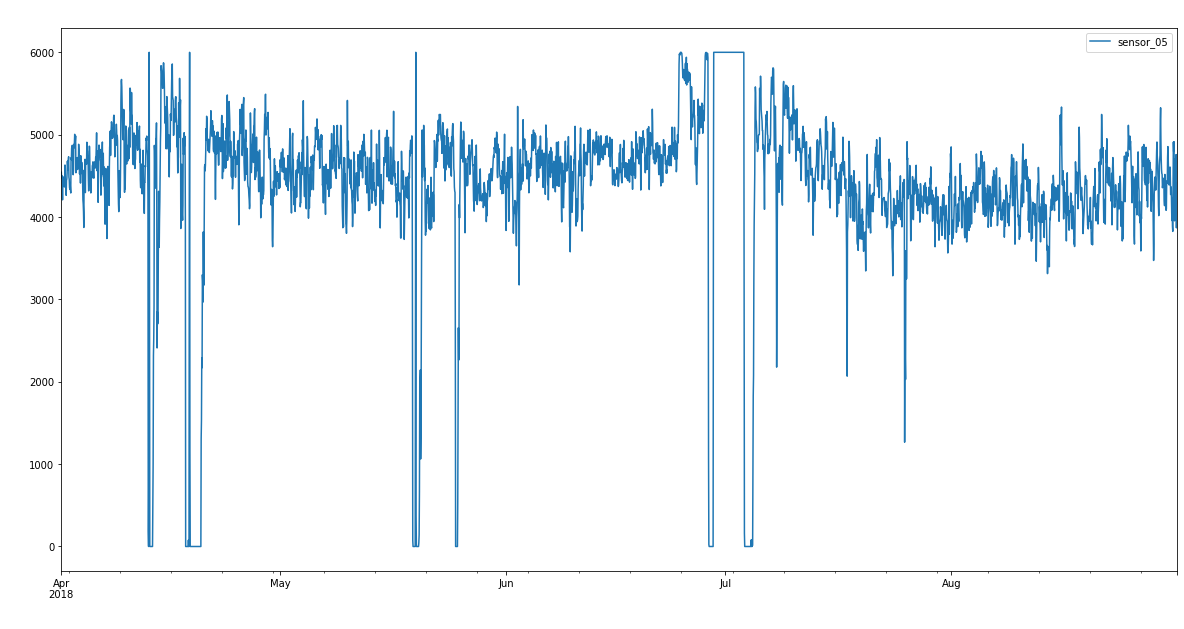

In [102]:
train_data[['sensor_05']].plot(figsize=(20,10))
plt.xlabel("Date", fontsize=18, color='white')
plt.ylabel("Value of sensor 05", fontsize=18, color='white')
plt.title('Value of sensor 05 during time', fontsize=20, color='white');

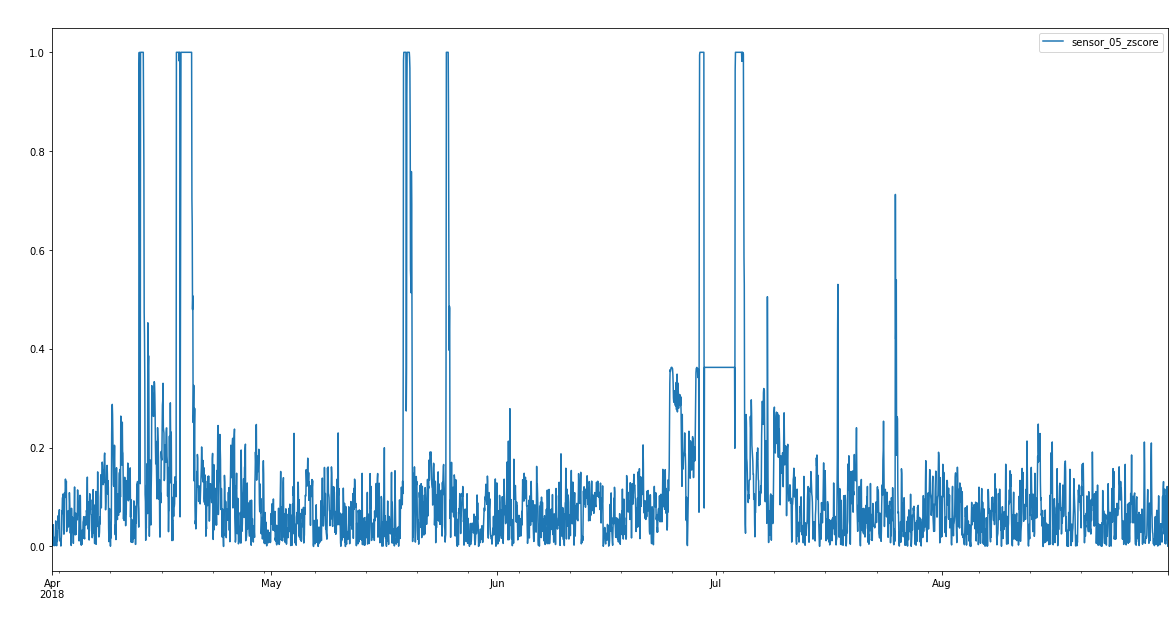

In [103]:
zScore_df[['sensor_05_zscore']].plot(figsize=(20,10))
plt.xlabel("Date", fontsize=18, color='white')
plt.ylabel("Zscore of sensor 05", fontsize=18, color='white')
plt.title('Zscore of sensor 05 during time', fontsize=20, color='white');